# AM207 Final Report
# Bayesket Ball: A Bayesian Take on College Basketball

Stephen Fang, Micah Lanier, Jeffrey (Shih-kai) Shen


# Abstract

Featuring 351 teams, NCAA men’s basketball is a major source of excitement in American sports. The annual 64-team NCAA tournament attracts more advertising spending than the Super Bowl, and prompts $12 billion in gambling on its outcome.

Our goal: apply Bayesian statistical analysis to determine what team features predict game outcomes, and simulate the 2015 NCAA tournament. We apply lessons from AM 207 to construct and sample from a complex model parameter space.


<hr/>

# Introduction

Featuring 351 first division men’s teams, college basketball is a major source of excitement in American sports. The annual NCAA Tournament regularly attracts more advertising spending than the Super Bowl, and tens of millions of Americans pore over box scores and statistics to win a share of the $12 billion in associated gambling transactions. In that tradition—making predictions, not indulging our vices—we are interested in applying Bayesian analysis of basketball team characteristics to predicting game outcomes. We will use past years’ data when building our model, and evaluate its performance using actual game results from the 2014-15 season and tournament.

<hr/>

# Related Work

Naturally, our interest in this predictive task is far from unique. Mainstream news organizations regularly publish probabilistic predictions of game outcomes, especially during March Madness. There exist academic treatments of the topic as well—Lopez and Matthews recently applied an MLE logistic regression model to game outcomes that performed quite well when predicting winners in the 2014 tournament. In addition, paired comparison models are also used to predict outcomes of binary data such as the Coke/Pepsi Challenge and basketball games, and can provide a probabilistic interpretation using logistic regression.

From a Bayesian angle, our most direct inspiration for this project was the winning submission of the 2013 UseR Data Analysis Contest, featuring a hierarchical Bayesian Poisson model to predict Spanish soccer match scores. Allen Downey implemented a similar model in Think Bayes to predict the Boston Bruins’ Stanley Cup chances.

Our work will draw inspiration from the Bayesian bent of the latter works (and what we have learned in class thus far) and attempt to solve the problems of the former in a more sophisticated (and Bayesian!) manner.

<hr/>

# Data

Our analysis utilizes NCAA men’s basketball team statistics and game records from KenPom.com. We used Python’s BeautifulSoup to retrieve and extract game data. Before model fitting, we calculated differences of team features between opponents to quantify their relative (not absolute) attributes.

TODO

<hr/>

# Method

## Variable Selection

Despite all we have learned, iterating over Bayesian logistic regression model features is computationally intensive. Therefore, we decided to use the variable importance measure from random forests to decide which predictors to include in our Bayesian logistic regression. The variable importance measure is computed from permuting out-of-bag data: For each tree, the prediction classification error on the out-of-bag portion of the data is recorded. Then the same is done after permuting each predictor variable. The difference between the two are then averaged over all trees, and normalized by the standard deviation of the differences. The predictor with the most decrease in prediction accuracy would have the highest importance. 

We trained a random forest on the data set using location (home, away, or neutral) and quantitative features that measure the differences in the team statistics per game. We then computed the relative importance of each predictor and iterated over the N most important predictors. For each iteration, we estimated the test accuracy with 10-fold cross validation on the training data, 2015 regular season games. As shown in the chart below, as N increases, the cross-validation accuracy score increases but levels off after N = 5. Therefore, we included the 5 most important features from the random forest as our predictors: diff_Pythag, diff_AdjOE, diff_AdjDE, location_Away, and diff_RankAdjDE.

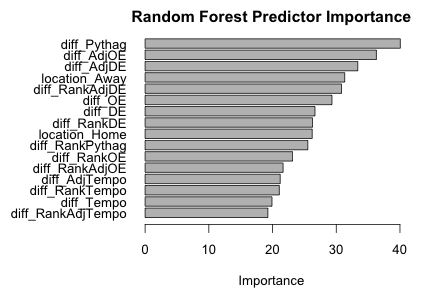

In [2]:
from IPython.display import Image
Image(filename='RF Importance.png')

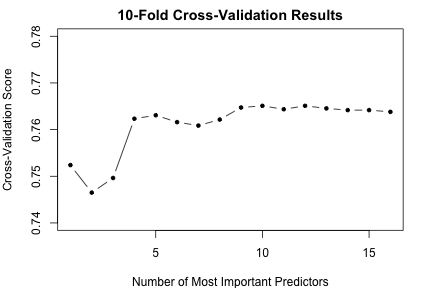

In [3]:
Image(filename='XVal Scores.png')

## Priors

As for priors for the Bayesian logistic regression, we fitted a logistic regression on 2014 data with the 5 predictors and assigned the coefficient estimates as the prior means shown in the Model section below. Since we do not have strong knowledge of the locations of the coefficients, we decided to assign a wide prior standard deviations for the coefficients at 10.

<hr/>

## Model Building

In this section, we describe the sampling techniques that we used to generate posterior Bayesian logit regression samples. Below, we used two well-known sampling algorithms: 1) Metropolis-Hastings Algorithm and 2) Slice Sampling Algorithms. We will also show several sampling diagnostics that will check for sample correlation and sampling convergence.

## Metropolis-Hastings Algorithm

We first sampled our Bayesian logistic regression using the well-known Metropolis-Hastings Algorithm. The following code will implement the sampling techniques. The main bayesian logistic regression code can be found in our custom module <strong>bayes_lr.py</strong>. The core sampling module is built on top of pymc.

In [74]:
### Libraries

import matplotlib, matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pymc

% matplotlib inline

In [246]:
### Custom Modules
import bayes_lr
import game_predictions

In [250]:
### Reloading Examples
bayes_lr = reload(bayes_lr)
game_predictions = reload(game_predictions)

In [77]:
### Settings

# Games path.
games_path = 'games_2015_tournament.csv'
priors_path = 'Priors.csv'

## Data

In [78]:
# Read games.
games = pd.read_csv(games_path)
# Trim to single group.
games = games[games.game_group == 1].reset_index(drop=True)
# 2015 games.
games_2015 = games[games.ncaa_tournament == 0].reset_index(drop=True)
# 2015 NCAA tournament games
games_2015_ncaa = games[games.ncaa_tournament == 1].reset_index(drop=True)

In [79]:
games_2015

,game_id,game_group,year,date,team,opponent,conference,conference_tournament,ncaa_tournament,other_tournament,...,ratio_RankAdjOE,ratio_RankAdjTempo,ratio_RankDE,ratio_RankOE,ratio_RankPythag,ratio_RankTempo,ratio_Tempo,points_for,points_against,win
0,20141114-airforce-army,1,2015,2014-11-14,Army,Air Force,0,0,0,0,...,3.034091,0.036184,0.782456,1.847826,1.290640,0.060790,1.134062,84,78,1
1,20141114-akron-umbc,1,2015,2014-11-14,Akron,UMBC,0,0,0,0,...,0.450867,1.445860,0.361502,0.368876,0.267442,0.948718,1.002438,74,57,1
2,20141114-alabama-towson,1,2015,2014-11-14,Towson,Alabama,0,0,0,0,...,4.033333,1.104377,1.552147,2.116505,4.344262,1.154122,0.974324,54,82,0
3,20141114-alabamaam-dayton,1,2015,2014-11-14,Alabama A&M,Dayton,0,0,0,0,...,4.191781,1.102804,11.333333,3.236559,8.250000,0.994975,1.000082,52,76,0
4,20141114-alcornst-california,1,2015,2014-11-14,Alcorn St.,California,0,0,0,0,...,1.790055,0.584906,2.294964,1.366379,2.982759,0.533981,1.020971,57,91,0
5,20141114-american-temple,1,2015,2014-11-14,American,Temple,0,0,0,0,...,1.092486,2.845528,10.200000,0.809322,3.321429,2.264516,0.876852,37,40,0
6,20141114-arizona-mountstmarys,1,2015,2014-11-14,Arizona,Mount St. Mary's,0,0,0,0,...,0.039286,0.287823,0.029412,0.065134,0.008929,0.298507,1.059393,78,55,1
7,20141114-arizonast-chicagost,1,2015,2014-11-14,Arizona St.,Chicago St.,0,0,0,0,...,0.200000,0.421053,0.403704,0.411594,0.208333,0.455939,1.044194,86,50,1
8,20141114-arkansaspinebluff-hawaii,1,2015,2014-11-14,Hawaii,Arkansas Pine Bluff,0,0,0,0,...,0.456456,0.067961,0.492063,0.433735,0.376543,0.120879,1.068176,85,57,1
9,20141114-auburn-milwaukee,1,2015,2014-11-14,Milwaukee,Auburn,0,0,0,0,...,1.398551,4.352941,1.139442,0.859922,1.408451,2.473684,0.967571,73,83,0


## Model

The following 5 features are selected as shown in the Variable Selection section above.

In [1]:
# TODO Bayesian logistic Equation

In [84]:
# Features.
features = ['diff_Pythag','diff_AdjOE','diff_AdjDE','location_Away','diff_RankAdjDE']

Next, we set the priors for our features listed above. We ran a logistic regression on all of the 2014 games and used the coefficients to inform us on how to set the priors for our Bayesian logistic regression. For our priors, we chose to use normals since the features are normally distributed. For the means, we use the estimate from the 2014 logistic regression. For the std, we chose 10 since the std error for the logistic regression are rather small.

In [85]:
# Set priors from 2014 logistic outputs
priors = pd.read_csv(priors_path)
priors.head()

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,(Intercept),0.495515,0.045759,10.828880,2.512097e-27
1,diff_Pythag,1.418366,1.025396,1.383237,1.665922e-01
2,diff_AdjOE,0.114664,0.023133,4.956645,7.172097e-07
3,diff_AdjDE,-0.141281,0.025689,-5.499668,3.805078e-08
4,location_Away,-1.054997,0.069461,-15.188397,4.221181e-52


In [102]:
# Priors
coef_dist_params = []
b0_params={'mu':priors.iloc[0][1], 'tau':10, 'value':0}
for i in range(1,len(features)+1):
    coef_dist_params.append({'mu':priors.iloc[i][1], 'tau':10, 'value':0})
coef_dist_params

[{'mu': 1.4183656505726498, 'tau': 10, 'value': 0},
 {'mu': 0.11466422117814901, 'tau': 10, 'value': 0},
 {'mu': -0.14128114425290603, 'tau': 10, 'value': 0},
 {'mu': -1.0549970470677299, 'tau': 10, 'value': 0},
 {'mu': 0.0015390113213159199, 'tau': 10, 'value': 0}]

After setting up the features and priors, we can now run the MH sampling algorithm. We chose a burn-in rate of 5,000 points after observing the trace plots. Next, we also chose to thin and take 1 sample out of every 10 samples (this is detailed below). In summary, we will 105,000 points because we burn 5,000 points and take 1/10 every points. We also used the default proposal distribution to sample the target distribution with a standard normal.

In [103]:
# Use our custom module bayes_lr.py
model_mcmc = bayes_lr.model_games(data=games_2015,features=features,b0_params=b0_params,coef_dist_params=coef_dist_params)

In [139]:
# MH sampling
model_mcmc.sample(105000,5000, thin=10)

 [-----------------100%-----------------] 105000 of 105000 complete in 161.1 sec

## MH Sampling Diagnostics

The following autocorrelation graph is from a previous iteration where we did not perform thinning. As we can see below, there is a high correlation for much of the samples. Thus, we chose to thin for MH.

Plotting b_diff_RankPythag
Plotting b_diff_RankAdjTempo
Plotting b_0
Plotting b_diff_DE
Plotting err
Plotting b_location_Home
Plotting b_diff_OE


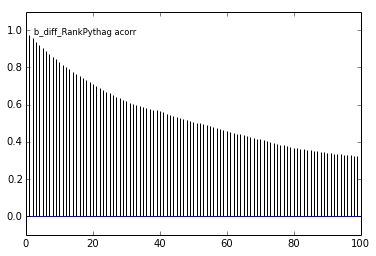

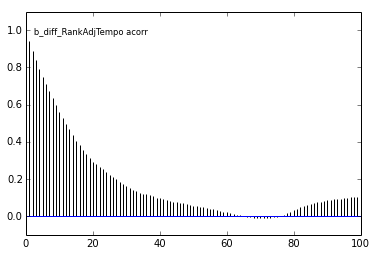

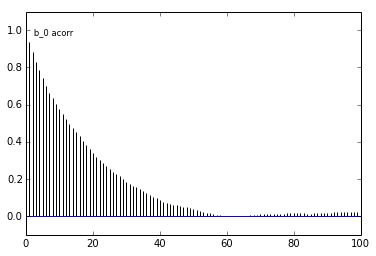

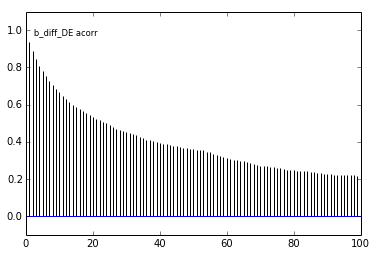

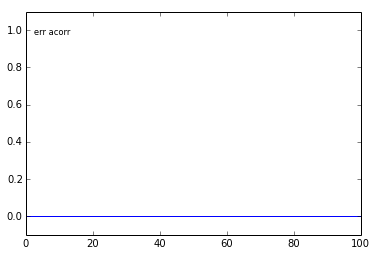

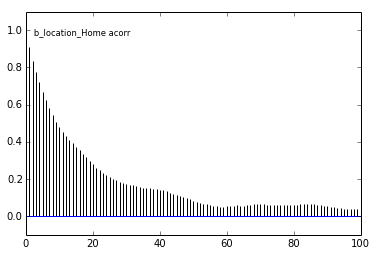

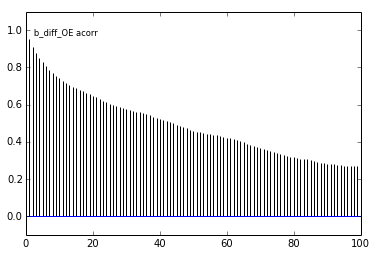

In [11]:
# No thinning
pymc.Matplot.autocorrelation(model_mcmc)

Contrasted to the autocorrelation plots above, after thinning, most of the autocorrelation disappeared in the autocorrelation plots below. This proved to us that we have non-correlated samples.

Plotting b_diff_AdjOE
Plotting b_diff_Pythag
Plotting b_diff_RankAdjDE
Plotting b_diff_AdjDE
Plotting err
Plotting b_location_Away
Plotting b_0


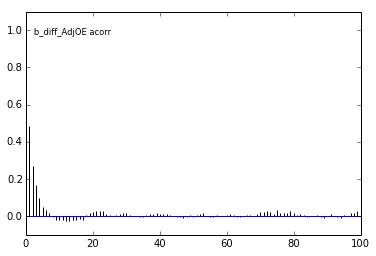

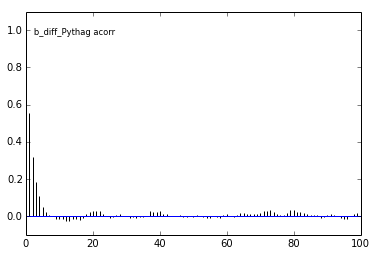

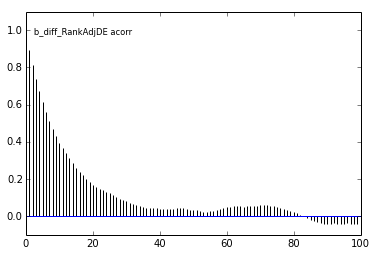

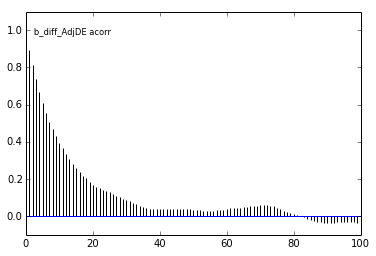

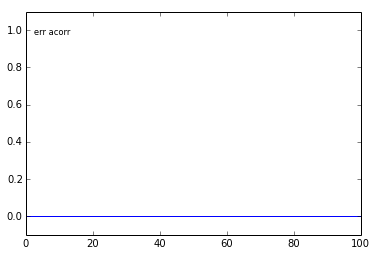

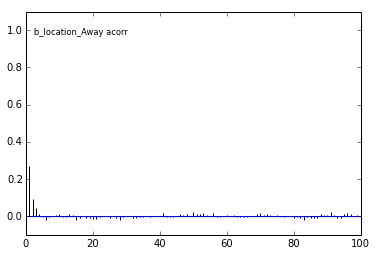

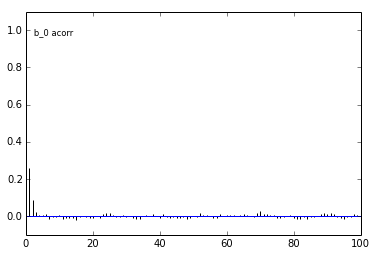

In [163]:
# With Thinning
pymc.Matplot.autocorrelation(model_mcmc)

Lastly, we looked at whether our sampling method actually converged. To do this, we used the Geweke statistics. As seen below, most of the points are found to be between +/-2. Therefore, it is safe to conclude that the MH algorithm did indeed converge. For this section, we used pymc's geweke function.

diff_Pythag
diff_AdjOE
diff_AdjDE
location_Away
diff_RankAdjDE


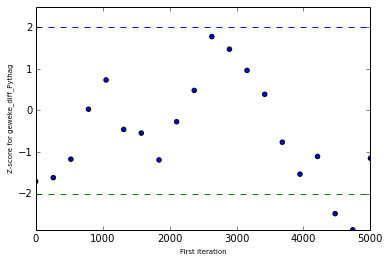

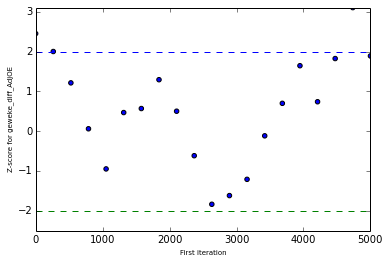

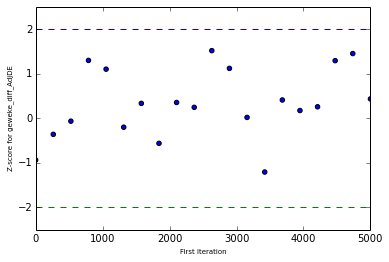

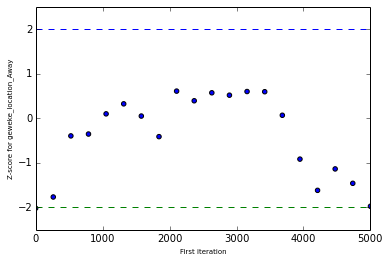

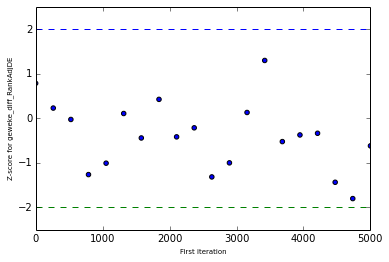

In [164]:
# Geweke Test
for feature in features:
    print feature
    scores = pymc.geweke(model_mcmc.trace('b_'+feature)[:])
    pymc.Matplot.geweke_plot(scores, name = 'geweke_'+feature)

In [252]:
geweke_scores = bayes_lr.geweke_statistics(model_mcmc,features)

diff_Pythag
diff_AdjOE
diff_AdjDE
location_Away
diff_RankAdjDE


Here is the compiled perspective of the Geweke statistics plots from above. As we can see most of statistics are between +/-2. 

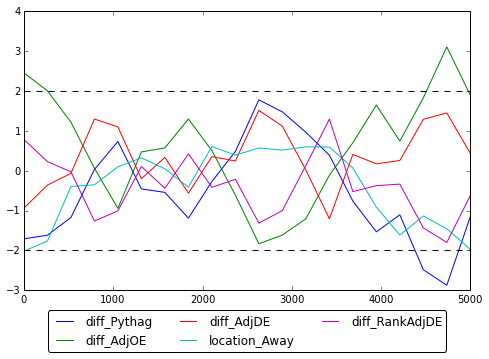

In [253]:
# Here is the plot with all of the Geweke statistics in one plot
# Use our custom module bayes_lr.py
bayes_lr.plot_Geweke(geweke_scores, features)

From the above, statistics, we can see that we have non-correlated samples and our sampling technique did indeed converge. Lastly, we can calculate the coefficients' mean and the standard deviation of the posterior distribution.

In [245]:
# Display means and standard deviation
# Coefficient, Mean, Standard Deviation
model_means = bayes_lr.mcmc_trace_means(model_mcmc, [str(0)]+ features, printMeans = True)

b_0 0.471805285536 0.0455916975225
b_diff_Pythag 1.12832576256 0.301363911592
b_diff_AdjOE 0.119028764371 0.00847965608605
b_diff_AdjDE -0.118342832331 0.0244586991776
b_location_Away -1.12138536422 0.0687945843362
b_diff_RankAdjDE 0.000345079539534 0.00142574907166


## Slice Sampling

Next, we tried another sampling method, slice sampling. Unlike Metropolis-Hastings, we do not have to specify a proposal function. Again, we use the priors from 2014 and do not thin since slice sampling guarantees samples with less correlated samples.

In [23]:
# Use our custom module bayes_lr.py
model_mcmc = bayes_lr.model_games(data=games_2015,features=features,b0_params=b0_params,coef_dist_params=coef_dist_params,
                                  step_method = pymc.Slicer)

In [24]:
model_mcmc.sample(15000,5000)

 [-----------------100%-----------------] 15000 of 15000 complete in 237.6 sec

Plotting b_0
Plotting b_diff_AdjDE
Plotting b_diff_RankAdjDE
Plotting b_diff_AdjOE
Plotting err
Plotting b_diff_Pythag
Plotting b_location_Away


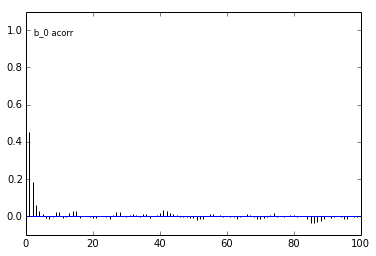

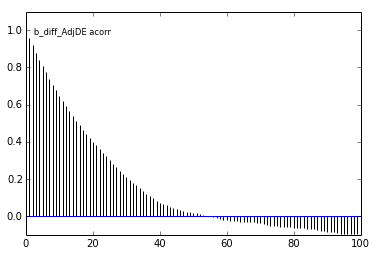

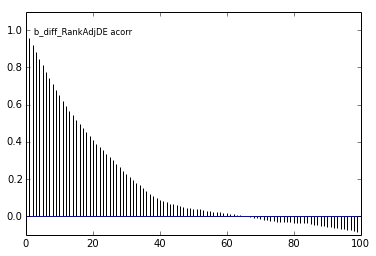

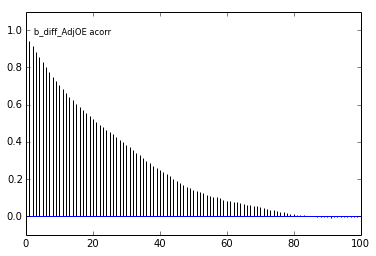

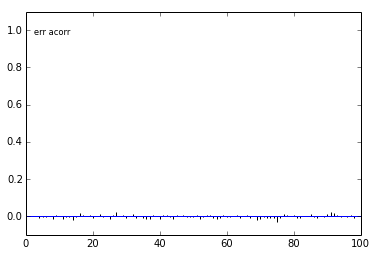

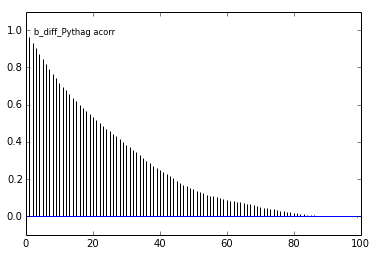

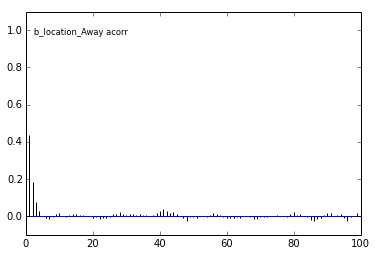

In [25]:
# No thinning
pymc.Matplot.autocorrelation(model_mcmc)

As we can see from the autocorrelation plots above, when compared with MH without thinning, slice sampling has much less correlation. Therefore, we chose not to thin the samples. In addition, from the Geweke statistics plots below show that our sampling method did indeed converge. All of the values are between +/-2.

diff_Pythag
diff_AdjOE
diff_AdjDE
location_Away
diff_RankAdjDE


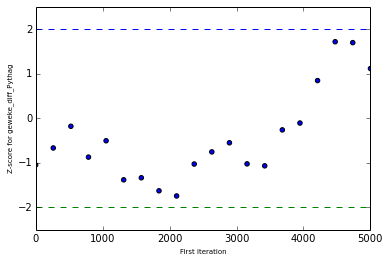

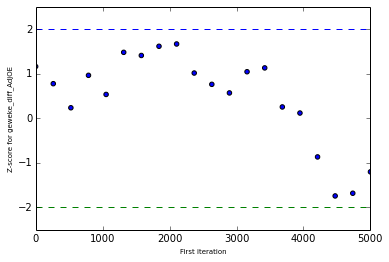

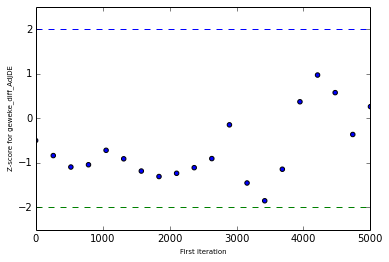

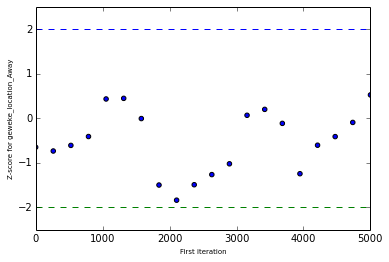

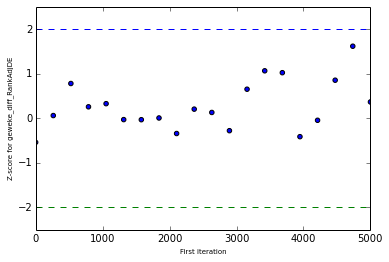

In [26]:
# Geweke Test
for feature in features:
    print feature
    scores = pymc.geweke(model_mcmc.trace('b_'+feature)[:])
    pymc.Matplot.geweke_plot(scores, name = 'geweke_'+feature)

In [37]:
geweke_scores = bayes_lr.geweke_statistics(model_mcmc,features)

diff_Pythag
diff_AdjOE
diff_AdjDE
location_Away
diff_RankAdjDE


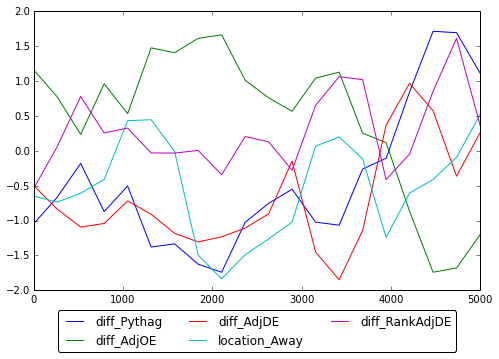

In [38]:
# Use our custom module bayes_lr.py
bayes_lr.plot_Geweke(geweke_scores, features)

In [27]:
# Display means and standard deviation
# Coefficient, Mean, Standard Deviation
model_means = bayes_lr.mcmc_trace_means(model_mcmc, [str(0)]+ features, printMeans = True)

b_0 0.474591688386 0.0457423533785
b_diff_Pythag -1.28967315394 0.95919952927
b_diff_AdjOE 0.172171680591 0.02197214043
b_diff_AdjDE -0.14484594726 0.0280039477914
b_location_Away -1.12754239685 0.0706660309504
b_diff_RankAdjDE -0.00134981353141 0.00165214382168


As we can see the posterior distribution results from slice sampling is very similar to those from MH. Therefore, we can be confident that we sampled the posterior distribution correctly. Using the two sets of results, we can use the coefficient samples for the 2015 NCAA simulations.

Finally, before the long-awaited simulations, we can do a quick sanity check on our Bayesian logistic regression to see how well it actually performs on the actual 2015 NCAA tournament. First we predicted the outcomes for all 10,000 sets of coefficients that we sampled from the posterior distribution and calculated the average accuracy. Next, we also the accuracy from a model that uses the MAP coefficients.

In [263]:
# Calculate the mean accuracy of 10,000 models
# Use our custom module bayes_lr.py
y_hat_raw, y_hat, y_hat_accuracy = game_predictions.predict_games(games_2015_ncaa, features,model_mcmc=model_mcmc, method='pp')

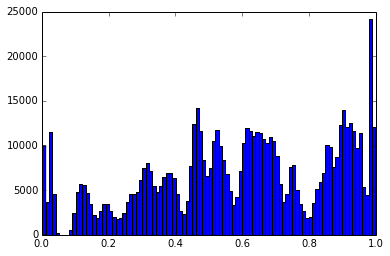

In [146]:
plt.hist(y_hat_raw.ravel(), bins=100);

In [265]:
np.shape(y_hat_raw)

(10000L, 67L)

In [266]:
# Accuracy of 10,000 coefficients
y_hat_accuracy

0.76643432835820891

In [256]:
# Calculate the mean accuracy of 10,000 models
# Use our custom module bayes_lr.py
y_hat_raw, y_hat, y_hat_accuracy = game_predictions.predict_games(games_2015_ncaa, features,model_mcmc=model_mcmc, method='map')

In [150]:
# Accuracy of MAP
y_hat_accuracy

0.76119402985074625

From the above, we see that the 10,000 coefficients produced an average of 76.64% accuracy and the MAP coefficients produced an accuracy of 76.12% on the actual 2015 NCAA tournament! We are very satisfied with these results. Similarly, the slice sampler's coefficients produced 75.98% and 76.11% accuracy. Both sampling techniques resulted in very similar results and we are quite confident in our results going into the NCAA tournament simulation.

<hr/>

# Discussion

<hr/>

# Conclusion